In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cmath
import sdeint

ヒルベルト変換によってデータから位相を取り出し、位相モデルのパラメータを最尤推定。

次のモデルを仮定してパラメータ$\omega_j, b_{jk}, \sigma_i^2$を推定。
$$\dot{\phi}_j = \omega_j + \sum_k b_{jk}\sin(\phi_k-\phi_j) + \eta_j (t)$$
を仮定する。
ただし、$\eta_j$はガウシアンホワイトノイズ。$\langle \eta_j \rangle = 0, \langle \eta_i(t_1) \eta_j(t_2) \rangle = \delta_{ij}\sigma_i^2\delta(t_1-t_2)$

データ　x[j][t] ：j番目のデータの時刻tの値。

## データxからモデルパラメータを最尤推定
注意：ノイズ強度の推定は未実装。

In [24]:
h = 0.01 #観測データの時間間隔
tau = 0.01 #データ生成の刻み幅
def MLE_phase_model(x):
    K = len(x) #振動子数
    T = len(x.T) #データ長
    #print(T)
    
    #xが位相データではない場合。ヒルベルト変換する。
    #analytic_signal = signal.hilbert(x)
    #phase = np.angle(analytic_signal) #-piからpiへジャンプがある。
    
    #xが位相データの場合
    analytic_signal = np.cos(x) + 1j*np.sin(x) 
    phase = x
    
    omegalist = np.array([])
    blist = np.array([])
    sigmalist = np.array([])
    
    #Diff_phase_k[t]は、(i,j)成分が時刻tにおける振動子i,jの位相差(phi_j - phi_i)であるような行列。
    Diff_phase_k = np.array([phase.T[t].reshape((1,K)) - (phase.T[t]).reshape((K,1)) for t in range(T-1)]).reshape(T-1, K, K)
    Diff_phase_t = np.angle(analytic_signal.T[1:] / analytic_signal.T[:T-1])  #位相のジャンプがないように、解析信号の偏角の差をとることで求める。
    #print(Diff_phase_t)
    for j in range(K):
        A1 = (np.sum(np.sin(Diff_phase_k), axis=0)[j]).reshape((1, K))
        #print(A1)
        A2 = np.sum(np.array([np.dot(np.sin(Diff_phase_k[t][j]).reshape((K,1)), np.sin(Diff_phase_k[t][j]).reshape((1,K))) for t in range(T-1)]), axis=0)
        AA1 = np.append(np.array([T-1]).reshape((1,1)), A1).reshape((1,K+1))
        #print(AA1)
        A_with_zero = np.append(AA1,   np.append(A1, A2, axis=0).T, axis=0)
        #print("zero vector?", A_with_zero[j+1])
        A = np.delete(np.delete(A_with_zero, j+1, 0), j+1, 1) * h
        #print("A=", A)
        
        
        DeltaPhi = Diff_phase_t.T[j]
        bb = np.array([ np.sum (np.array([np.sin(Diff_phase_k[t][j][i]) * DeltaPhi[t] for t in range(T-1) ])) for i in range(K)])
        b_with_zero = np.append(np.sum(DeltaPhi).reshape((1,1)), bb.reshape((1,K)), axis=1).T
        
        #b_with_zero =  (1/h)*np.append(np.sum(Diff_phase_t.T[j]).reshape((1,1)),  np.sum( np.dot((Diff_phase_t.T[j]).reshape((T-1,1)), np.ones((1,K))).reshape((T-1,K)) * (np.sin(Diff_phase_k)[:,j,:]).reshape((T-1, K)), axis=0).reshape((1,K)), axis=1 ).T
        b =  np.delete(b_with_zero, j+1)
        #print("b=", b)
        
        x = np.linalg.solve(A,b)
        omega = x[0]
        bj = np.delete(x, 0)
        
        sigma_double = (1/(T*h)) * np.sum ( ((Diff_phase_t.T[j]).reshape((1,T-1)) - h* (omega + np.dot(bj.reshape((1,K-1)), np.sin(np.delete(Diff_phase_k[:,j,:], j, axis=1).reshape((K-1, T-1)))))  )**2 ) 
        
        #print(np.shape(((Diff_phase_t.T[j]).reshape((1,T-1)) -  (omega + np.dot(bj.reshape((1,K-1)), np.sin(np.delete(Diff_phase_k[:,j,:], j, axis=1).reshape((K-1, T-1)))))  )**2 ))
        
        #print("固有周波数", j,  "=", omega)
        #print("結合強度", j,"=", bj)
        #print("ノイズ強度",j ,"=", np.sqrt(sigma_double))
        
        omegalist = np.append(omegalist, omega)
        blist = np.append(blist.reshape((len(blist), K-1)), bj.reshape((1, K-1)), axis=0)
        sigmalist = np.append(sigmalist, np.sqrt(sigma_double))
        
    return omegalist, blist, sigmalist
        
        

In [14]:
np.append(np.array([]).reshape((0,3)), np.array([1,2,3]).reshape((1,3)),axis=0)

array([[1., 2., 3.]])

## データ生成
### 最尤推定において仮定した位相モデル

In [8]:
num_node = 3 #振動子数
omega0 = np.array([6.28, 6.28, 5.0]) #固有周波数
Connectivity_Matrix0 = np.array([[0,0.2, 0.1], [0.1,0, 0.1], [0.1, 0.2, 0]]) 

sigma0 = np.diag(np.ones(num_node)* 0.01)


def G_whitenoise(x,t):
    return sigma0
    
def phase_model(y, t): #tとyの順番
    sogosayo = np.diag(np.dot(np.sin(y.reshape((1, num_node)) - y.reshape((num_node, 1))), Connectivity_Matrix0.T))
    return (omega0 +  sogosayo )


### データ生成

In [17]:
x_init= np.array([0, 0.1, 0.2]) #初期値
T0 = 1000
tspan0 = np.linspace(0.0, T0, int(T0/tau)+1)
result0 = sdeint.itoint(f=phase_model, G=G_whitenoise, y0=x_init, tspan=tspan0)


### 推定

In [25]:
print("推定値：")
#omega_est, b_est, sigma_est = MLE_phase_model((result0).T)
for j in range(num_node):
    print("固有周波数", j,  "=", omega_est[j])
    print("結合強度", j,"=", b_est[j])
    print("ノイズ強度",j ,"=",sigma_est[j])
    

print("\nデータ生成で用いたパラメータ：")
for j in range(num_node):
    print("固有周波数", j,  "=", omega0[j])
    print("結合強度", j,"=", np.delete(Connectivity_Matrix0[j], j))
    print("ノイズ強度",j ,"=", sigma0[j][j])
        


推定値：
固有周波数 0 = 6.279692479417218
結合強度 0 = [0.21065775 0.0996982 ]
ノイズ強度 0 = 0.01657717657095909
固有周波数 1 = 6.2803985686273744
結合強度 1 = [0.07727338 0.10047086]
ノイズ強度 1 = 0.01368907024041137
固有周波数 2 = 5.000051047120608
結合強度 2 = [0.12391107 0.17619403]
ノイズ強度 2 = 0.027587705734546282

データ生成で用いたパラメータ：
固有周波数 0 = 6.28
結合強度 0 = [0.2 0.1]
ノイズ強度 0 = 0.01
固有周波数 1 = 6.28
結合強度 1 = [0.1 0.1]
ノイズ強度 1 = 0.01
固有周波数 2 = 5.0
結合強度 2 = [0.1 0.2]
ノイズ強度 2 = 0.01


### 小林先生のコードで生成したデータ

In [93]:
result1 = np.loadtxt("Sin_Coupled/matsuki_test.dat")

In [94]:
result1 = np.delete(result1,0,  axis=1)

In [96]:
np.shape(result1)

(20000, 2)

## 推定値が収束することを確認

In [106]:
Tlist = np.linspace(1000, len(result0)-1,101)
omega_est = np.array([])
b_est = np.array([])
sigma_est = np.array([])


for tt in Tlist:
    print(tt)
    omega, b, sigma = MLE_phase_model((result0[:int(tt)]).T)
    omega_est = np.append(omega_est.reshape((len(omega_est), num_node)), omega.reshape((1,num_node)), axis=0)
    b_est = np.append(b_est.reshape((len(b_est), num_node, num_node-1)), b.reshape((1,num_node,num_node-1)), axis=0)
    sigma_est = np.append(sigma_est.reshape((len(sigma_est), num_node)), sigma.reshape((1,num_node)), axis=0)    


1000.0
1990.0
2980.0
3970.0
4960.0
5950.0
6940.0
7930.0
8920.0
9910.0
10900.0
11890.0
12880.0
13870.0
14860.0
15850.0
16840.0
17830.0
18820.0
19810.0
20800.0
21790.0
22780.0
23770.0
24760.0
25750.0
26740.0
27730.0
28720.0
29710.0
30700.0
31690.0
32680.0
33670.0
34660.0
35650.0
36640.0
37630.0
38620.0
39610.0
40600.0
41590.0
42580.0
43570.0
44560.0
45550.0
46540.0
47530.0
48520.0
49510.0
50500.0
51490.0
52480.0
53470.0
54460.0
55450.0
56440.0
57430.0
58420.0
59410.0
60400.0
61390.0
62380.0
63370.0
64360.0
65350.0
66340.0
67330.0
68320.0
69310.0
70300.0
71290.0
72280.0
73270.0
74260.0
75250.0
76240.0
77230.0
78220.0
79210.0
80200.0
81190.0
82180.0
83170.0
84160.0
85150.0
86140.0
87130.0
88120.0
89110.0
90100.0
91090.0
92080.0
93070.0
94060.0
95050.0
96040.0
97030.0
98020.0
99010.0
100000.0


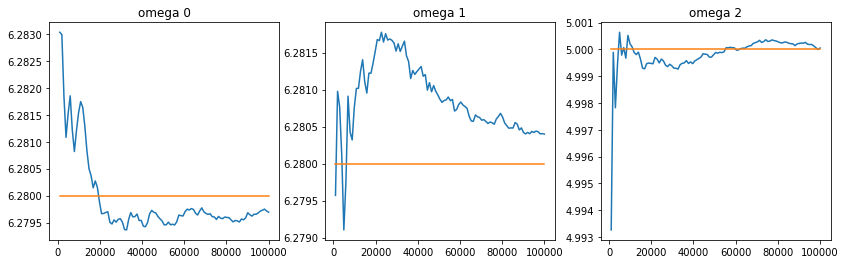

In [107]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,4))


#ax1.subplot(1,3,1)
ax1.set_title("omega 0")
ax1.plot(Tlist, omega_est.T[0])
ax1.plot(Tlist, np.ones(len(Tlist)) *omega0[0])

#plt.subplot(1,3,2)
ax2.set_title("omega 1")
ax2.plot(Tlist, omega_est.T[1])
ax2.plot(Tlist, np.ones(len(Tlist)) * omega0[1])


#ax3.subplot(1,3,3)
ax3.set_title("omega 2")
ax3.plot(Tlist, omega_est.T[2])
ax3.plot(Tlist, np.ones(len(Tlist)) * omega0[2])

fig.show()

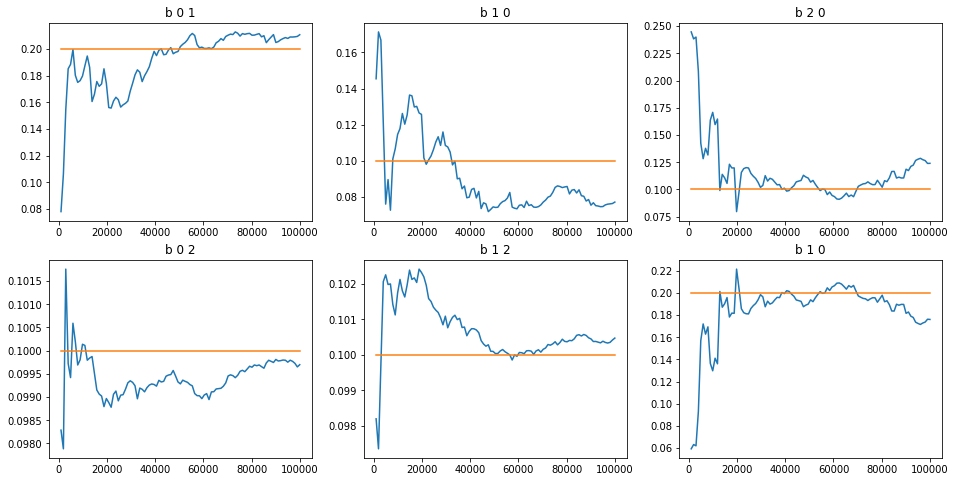

In [108]:
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((2,3), (0,0))
ax2 = plt.subplot2grid((2,3), (1,0))
ax3 = plt.subplot2grid((2,3), (0,1))
ax4 = plt.subplot2grid((2,3), (1,1))
ax5 = plt.subplot2grid((2,3), (0,2))
ax6 = plt.subplot2grid((2,3), (1,2))

#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=2, nrows=3, figsize=(14,20))


#ax1.subplot(1,3,1)
ax1.set_title("b 0 1")
ax1.plot(Tlist, b_est.T[0][0])
ax1.plot(Tlist, np.ones(len(Tlist)) *Connectivity_Matrix0[0][1]) 


#plt.subplot(1,3,2)
ax2.set_title("b 0 2")
ax2.plot(Tlist, b_est.T[1][0])
ax2.plot(Tlist, np.ones(len(Tlist)) * Connectivity_Matrix0[0][2])


#ax3.subplot(1,3,3)
ax3.set_title("b 1 0")
ax3.plot(Tlist, b_est.T[0][1])
ax3.plot(Tlist, np.ones(len(Tlist)) *Connectivity_Matrix0[1][0]) 

ax4.set_title("b 1 2")
ax4.plot(Tlist, b_est.T[1][1])
ax4.plot(Tlist, np.ones(len(Tlist)) *Connectivity_Matrix0[1][2]) 

ax5.set_title("b 2 0")
ax5.plot(Tlist, b_est.T[0][2])
ax5.plot(Tlist, np.ones(len(Tlist)) *Connectivity_Matrix0[2][0]) 

ax6.set_title("b 1 0")
ax6.plot(Tlist, b_est.T[1][2])
ax6.plot(Tlist, np.ones(len(Tlist)) *Connectivity_Matrix0[2][1]) 


fig.show()

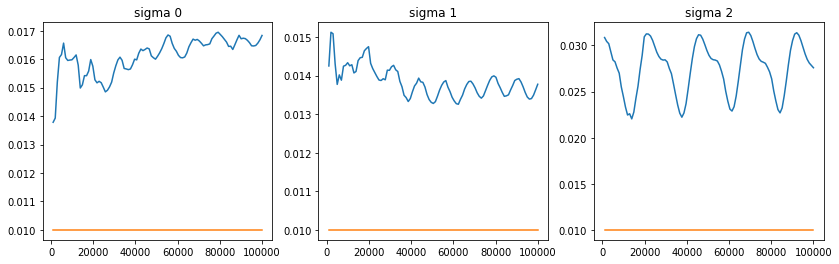

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14,4))


#ax1.subplot(1,3,1)
ax1.set_title("sigma 0")
ax1.plot(Tlist, sigma_est.T[0])
ax1.plot(Tlist, np.ones(len(Tlist)) *0.01)

#plt.subplot(1,3,2)
ax2.set_title("sigma 1")
ax2.plot(Tlist, sigma_est.T[1])
ax2.plot(Tlist, np.ones(len(Tlist)) * 0.01)


#ax3.subplot(1,3,3)
ax3.set_title("sigma 2")
ax3.plot(Tlist, sigma_est.T[2])
ax3.plot(Tlist, np.ones(len(Tlist)) * 0.01)

fig.show()